# Flair NLP Framework

In [ ]:
!pip install --upgrade flair==0.11.1
!pip install torch
!pip install importlib-metadata
!pip install emoji
!pip install nltk
!pip install sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.2 MB 9.3 MB/s 
     |████████████████████████████████| 48 kB 6.3 MB/s 
     |████████████████████████████████| 4.2 MB 38.4 MB/s 
     |████████████████████████████████| 788 kB 12.5 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 19.7 MB 12.9 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████| 981 kB 58.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.7 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 199 kB 73.2 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |██████████████████████████

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import joblib
from flair.data import Corpus, Sentence
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus, TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerDocumentEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.hyperparameter.param_selection import SearchSpace, Parameter
from flair.hyperparameter.param_selection import TextClassifierParamSelector, OptimizationValue
from hyperopt import hp
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from typing import List

from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.optim.adam import Adam
torch.cuda.is_available()


Mounted at /content/drive


True

# Paths

In [ ]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_corpus = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/data.csv"  

path_flair = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/"
path_flair_train = path_flair+"train.csv"
path_flair_dev = path_flair+"dev.csv"
path_flair_test = path_flair+"test.csv"

path_model_hyperparameters_distilbert = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert"
path_model_hyperparameters_distilbert_mb3 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert_mb3"
path_model_hyperparameters_distilbert_mb4 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert_mb4"
path_model_hyperparameters_distilbert_mb4_2 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert_mb4_2"
path_model_hyperparameters_distilbert_mb5 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilbert_mb5"


# Data Exploration

,tweet,label
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


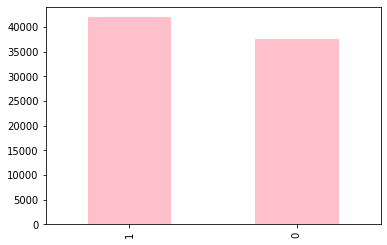

In [ ]:
data = pd.read_csv(path_corpus)

data['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))
data.head()

# Fast text format and split Dataset

In [ ]:
data['label'] = '__label__' + data['label'].astype(str)

train, test = train_test_split(data, test_size=0.2, random_state = 453, stratify=data['label'])
test, dev = train_test_split(test, test_size=0.5 , random_state = 453, stratify= test['label'])

train.to_csv(path_flair_train, sep='\t', index = False, header = False)
test.to_csv(path_flair_test, sep='\t', index = False, header = False)
dev.to_csv(path_flair_dev, sep='\t', index = False, header = False)

train.head(5)

,tweet,label
21782,@DianH4 @ExposeFalsehood .....80% of Afghan ci...,__label__1
28378,Having a high level of toxicity in your commun...,__label__1
33213,I started school in Darwin 1971...Cheesy warm ...,__label__1
59425,this is what #waiting at 2:30am for the shuttl...,__label__0
52405,home sweet second home... #vegas #girltime #d...,__label__0


# Hyperparameter tunning

## Distilbert

In [ ]:
column_name_map = {0: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',   # tab-separated files
                                         label_type= "label")
print(corpus)

2022-05-29 19:52:48,217 Reading data from /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape
2022-05-29 19:52:48,221 Train: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/train.csv
2022-05-29 19:52:48,222 Dev: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/dev.csv
2022-05-29 19:52:48,225 Test: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/test.csv
Corpus: 63722 train + 7965 dev + 7964 test sentences


In [ ]:
# Part 1 Mini Batch size 3
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-3, 5.0e-2])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[3])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilbert-base-uncased'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilbert_mb3, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=2)

2022-05-29 19:53:54,848 Computing label dictionary. Progress:


63722it [00:34, 1873.51it/s]

2022-05-29 19:54:28,876 Dictionary created for label 'label' with 3 values: __label__1 (seen 33590 times), __label__0 (seen 30132 times)
  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

2022-05-29 19:54:28,889 ----------------------------------------------------------------------------------------------------
2022-05-29 19:54:28,891 Evaluation run: 1
2022-05-29 19:54:28,897 Evaluating parameter combination:
2022-05-29 19:54:28,900 	learning_rate: 0.005
2022-05-29 19:54:28,902 	mini_batch_size: 3
2022-05-29 19:54:28,904 	model: distilbert-base-uncased
2022-05-29 19:54:28,905 ----------------------------------------------------------------------------------------------------
2022-05-29 19:54:28,907 ----------------------------------------------------------------------------------------------------
2022-05-29 19:54:28,908 Training run: 1


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

2022-05-29 19:55:23,092 ----------------------------------------------------------------------------------------------------
2022-05-29 19:55:23,097 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_featur

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 10/2655 [00:00<00:28, 93.85it/s]

  1%|          | 20/2655 [00:00<00:28, 93.43it/s]

  1%|1         | 30/2655 [00:00<00:28, 93.21it/s]

  2%|1         | 40/2655 [00:00<00:27, 93.84it/s]

  2%|1         | 50/2655 [00:00<00:27, 95.05it/s]

  2%|2         | 60/2655 [00:00<00:27, 95.07it/s]

  3%|2         | 70/2655 [00:00<00:27, 95.07it/s]

  3%|3         | 80/2655 [00:00<00:26, 95.81it/s]

  3%|3         | 90/2655 [00:00<00:27, 93.33it/s]

  4%|3         | 101/2655 [00:01<00:26, 96.63it/s]

  4%|4         | 111/2655 [00:01<00:26, 96.26it/s]

  5%|4         | 122/2655 [00:01<00:25, 97.95it/s]

  5%|4         | 132/2655 [00:01<00:26, 96.75it/s]

  5%|5         | 143/2655 [00:01<00:25, 99.01it/s]

  6%|5         | 153/2655 [00:01<00:25, 97.57it/s]

  6%|6         | 163/2655 [00:01<00:25, 97.43it/s]

  7%|6         | 173/2655 [00:01<00:25, 96.96it/s]

  7%|6         | 183/2655 [00:01<00:25, 96.55it/s]

  7%|7         | 193/2655 [00:0

2022-05-29 20:06:56,338 Evaluating as a multi-label problem: False
2022-05-29 20:06:56,399 DEV : loss 0.08203308284282684 - f1-score (micro avg)  0.9056
2022-05-29 20:07:01,055 BAD EPOCHS (no improvement): 0
2022-05-29 20:07:01,064 ----------------------------------------------------------------------------------------------------
2022-05-29 20:08:07,759 epoch 2 - iter 2124/21241 - loss 0.07848707 - samples/sec: 100.42 - lr: 0.005000
2022-05-29 20:09:14,116 epoch 2 - iter 4248/21241 - loss 0.07810655 - samples/sec: 100.89 - lr: 0.005000
2022-05-29 20:10:21,226 epoch 2 - iter 6372/21241 - loss 0.08002538 - samples/sec: 100.65 - lr: 0.005000
2022-05-29 20:11:27,594 epoch 2 - iter 8496/21241 - loss 0.07913940 - samples/sec: 100.91 - lr: 0.005000
2022-05-29 20:12:34,220 epoch 2 - iter 10620/21241 - loss 0.07833017 - samples/sec: 100.58 - lr: 0.005000
2022-05-29 20:13:40,944 epoch 2 - iter 12744/21241 - loss 0.07867442 - samples/sec: 100.73 - lr: 0.005000
2022-05-29 20:14:47,279 epoch 2 - i

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 10/2655 [00:00<00:26, 99.75it/s]

  1%|          | 20/2655 [00:00<00:27, 95.89it/s]

  1%|1         | 30/2655 [00:00<00:27, 96.05it/s]

  2%|1         | 40/2655 [00:00<00:27, 96.71it/s]

  2%|1         | 50/2655 [00:00<00:26, 97.35it/s]

  2%|2         | 60/2655 [00:00<00:26, 97.65it/s]

  3%|2         | 70/2655 [00:00<00:26, 96.40it/s]

  3%|3         | 80/2655 [00:00<00:26, 96.25it/s]

  3%|3         | 90/2655 [00:00<00:26, 96.42it/s]

  4%|3         | 100/2655 [00:01<00:26, 95.46it/s]

  4%|4         | 111/2655 [00:01<00:26, 97.43it/s]

  5%|4         | 121/2655 [00:01<00:26, 96.63it/s]

  5%|4         | 131/2655 [00:01<00:26, 96.86it/s]

  5%|5         | 141/2655 [00:01<00:25, 97.37it/s]

  6%|5         | 152/2655 [00:01<00:25, 99.69it/s]

  6%|6         | 162/2655 [00:01<00:25, 96.97it/s]

  6%|6         | 172/2655 [00:01<00:25, 97.41it/s]

  7%|6         | 182/2655 [00:01<00:25, 98.15it/s]

  7%|7         | 192/2655 [00:0

2022-05-29 20:18:34,485 Evaluating as a multi-label problem: False
2022-05-29 20:18:34,543 DEV : loss 0.08556140214204788 - f1-score (micro avg)  0.9111
2022-05-29 20:18:39,102 BAD EPOCHS (no improvement): 0
2022-05-29 20:18:39,111 ----------------------------------------------------------------------------------------------------
2022-05-29 20:19:45,537 epoch 3 - iter 2124/21241 - loss 0.07008776 - samples/sec: 100.78 - lr: 0.005000
2022-05-29 20:20:51,927 epoch 3 - iter 4248/21241 - loss 0.06789358 - samples/sec: 100.88 - lr: 0.005000
2022-05-29 20:21:58,107 epoch 3 - iter 6372/21241 - loss 0.06654200 - samples/sec: 101.19 - lr: 0.005000
2022-05-29 20:23:04,690 epoch 3 - iter 8496/21241 - loss 0.06588463 - samples/sec: 101.48 - lr: 0.005000
2022-05-29 20:24:11,096 epoch 3 - iter 10620/21241 - loss 0.06673042 - samples/sec: 100.87 - lr: 0.005000
2022-05-29 20:25:17,174 epoch 3 - iter 12744/21241 - loss 0.06732075 - samples/sec: 101.33 - lr: 0.005000
2022-05-29 20:26:23,562 epoch 3 - i

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 11/2655 [00:00<00:25, 103.51it/s]

  1%|          | 22/2655 [00:00<00:25, 101.40it/s]

  1%|1         | 33/2655 [00:00<00:27, 94.89it/s] 

  2%|1         | 43/2655 [00:00<00:27, 95.95it/s]

  2%|1         | 53/2655 [00:00<00:26, 96.40it/s]

  2%|2         | 64/2655 [00:00<00:26, 98.50it/s]

  3%|2         | 74/2655 [00:00<00:26, 97.62it/s]

  3%|3         | 84/2655 [00:00<00:27, 94.05it/s]

  4%|3         | 94/2655 [00:00<00:27, 94.62it/s]

  4%|3         | 104/2655 [00:01<00:26, 96.09it/s]

  4%|4         | 114/2655 [00:01<00:26, 94.20it/s]

  5%|4         | 125/2655 [00:01<00:26, 96.10it/s]

  5%|5         | 135/2655 [00:01<00:26, 93.57it/s]

  5%|5         | 145/2655 [00:01<00:26, 95.17it/s]

  6%|5         | 156/2655 [00:01<00:25, 97.49it/s]

  6%|6         | 166/2655 [00:01<00:25, 96.10it/s]

  7%|6         | 176/2655 [00:01<00:25, 96.34it/s]

  7%|7         | 187/2655 [00:01<00:25, 98.24it/s]

  7%|7         | 197/2655 [0

2022-05-29 20:30:10,017 Evaluating as a multi-label problem: False
2022-05-29 20:30:10,087 DEV : loss 0.0942445769906044 - f1-score (micro avg)  0.9112
2022-05-29 20:30:14,693 BAD EPOCHS (no improvement): 0
2022-05-29 20:30:14,702 ----------------------------------------------------------------------------------------------------
2022-05-29 20:30:14,707 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 8/2655 [00:00<00:34, 77.04it/s]

  1%|          | 16/2655 [00:00<00:33, 77.91it/s]

  1%|          | 25/2655 [00:00<00:32, 82.08it/s]

  1%|1         | 34/2655 [00:00<00:31, 84.47it/s]

  2%|1         | 43/2655 [00:00<00:30, 85.49it/s]

  2%|1         | 53/2655 [00:00<00:29, 87.99it/s]

  2%|2         | 63/2655 [00:00<00:28, 89.76it/s]

  3%|2         | 73/2655 [00:00<00:28, 90.47it/s]

  3%|3         | 83/2655 [00:00<00:30, 85.38it/s]

  3%|3         | 92/2655 [00:01<00:32, 77.74it/s]

  4%|3         | 100/2655 [00:01<00:34, 73.71it/s]

  4%|4         | 108/2655 [00:01<00:34, 74.30it/s]

  4%|4         | 116/2655 [00:01<00:34, 73.22it/s]

  5%|4         | 124/2655 [00:01<00:35, 72.28it/s]

  5%|4         | 132/2655 [00:01<00:34, 73.81it/s]

  5%|5         | 142/2655 [00:01<00:31, 79.97it/s]

  6%|5         | 152/2655 [00:01<00:29, 85.02it/s]

  6%|6         | 163/2655 [00:01<00:27, 90.83it/s]

  7%|6         | 173/2655 [00:02<

2022-05-29 20:30:42,817 Evaluating as a multi-label problem: False
2022-05-29 20:30:42,877 0.9126	0.9126	0.9126	0.9126
2022-05-29 20:30:42,879 
Results:
- F-score (micro) 0.9126
- F-score (macro) 0.9122
- Accuracy 0.9126

By class:
              precision    recall  f1-score   support

  __label__1     0.9095    0.9264    0.9179      4199
  __label__0     0.9162    0.8972    0.9066      3765

    accuracy                         0.9126      7964
   macro avg     0.9129    0.9118    0.9122      7964
weighted avg     0.9127    0.9126    0.9126      7964

2022-05-29 20:30:42,884 ----------------------------------------------------------------------------------------------------
2022-05-29 20:30:42,892 ----------------------------------------------------------------------------------------------------
2022-05-29 20:30:42,893 Done evaluating parameter combination:
2022-05-29 20:30:42,897 	learning_rate: 0.005
2022-05-29 20:30:42,899 	mini_batch_size: 3
2022-05-29 20:30:42,903 	model: distil

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 11/2655 [00:00<00:24, 109.58it/s]

  1%|          | 22/2655 [00:00<00:24, 106.18it/s]

  1%|1         | 33/2655 [00:00<00:25, 102.45it/s]

  2%|1         | 44/2655 [00:00<00:25, 102.11it/s]

  2%|2         | 55/2655 [00:00<00:26, 99.31it/s] 

  2%|2         | 65/2655 [00:00<00:26, 98.97it/s]

  3%|2         | 75/2655 [00:00<00:26, 98.95it/s]

  3%|3         | 86/2655 [00:00<00:25, 99.94it/s]

  4%|3         | 96/2655 [00:00<00:25, 99.43it/s]

  4%|3         | 106/2655 [00:01<00:25, 99.00it/s]

  4%|4         | 118/2655 [00:01<00:24, 102.54it/s]

  5%|4         | 129/2655 [00:01<00:25, 100.26it/s]

  5%|5         | 140/2655 [00:01<00:24, 102.49it/s]

  6%|5         | 151/2655 [00:01<00:24, 103.54it/s]

  6%|6         | 162/2655 [00:01<00:24, 101.67it/s]

  7%|6         | 173/2655 [00:01<00:24, 102.58it/s]

  7%|6         | 184/2655 [00:01<00:24, 102.10it/s]

  7%|7         | 195/2655 [00:01<00:25, 98.18it/s] 

  8%|7         | 2

2022-05-29 20:42:42,866 Evaluating as a multi-label problem: False
2022-05-29 20:42:42,925 DEV : loss 0.08305945992469788 - f1-score (micro avg)  0.8917
2022-05-29 20:42:47,448 BAD EPOCHS (no improvement): 0
2022-05-29 20:42:47,453 ----------------------------------------------------------------------------------------------------
2022-05-29 20:43:52,705 epoch 2 - iter 2124/21241 - loss 0.08896760 - samples/sec: 102.41 - lr: 0.050000
2022-05-29 20:44:59,979 epoch 2 - iter 4248/21241 - loss 0.08800162 - samples/sec: 99.52 - lr: 0.050000
2022-05-29 20:46:08,597 epoch 2 - iter 6372/21241 - loss 0.08758293 - samples/sec: 97.77 - lr: 0.050000
2022-05-29 20:47:16,130 epoch 2 - iter 8496/21241 - loss 0.08810652 - samples/sec: 99.93 - lr: 0.050000
2022-05-29 20:48:23,908 epoch 2 - iter 10620/21241 - loss 0.08822795 - samples/sec: 98.81 - lr: 0.050000
2022-05-29 20:49:30,452 epoch 2 - iter 12744/21241 - loss 0.08833544 - samples/sec: 100.59 - lr: 0.050000
2022-05-29 20:50:36,558 epoch 2 - iter 

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 11/2655 [00:00<00:25, 104.82it/s]

  1%|          | 22/2655 [00:00<00:27, 95.80it/s] 

  1%|1         | 32/2655 [00:00<00:27, 95.48it/s]

  2%|1         | 42/2655 [00:00<00:27, 94.78it/s]

  2%|1         | 52/2655 [00:00<00:28, 92.29it/s]

  2%|2         | 62/2655 [00:00<00:28, 91.14it/s]

  3%|2         | 72/2655 [00:00<00:27, 92.50it/s]

  3%|3         | 82/2655 [00:00<00:28, 91.89it/s]

  3%|3         | 92/2655 [00:00<00:27, 93.07it/s]

  4%|3         | 102/2655 [00:01<00:27, 93.22it/s]

  4%|4         | 112/2655 [00:01<00:26, 94.30it/s]

  5%|4         | 122/2655 [00:01<00:26, 93.92it/s]

  5%|4         | 132/2655 [00:01<00:27, 93.40it/s]

  5%|5         | 142/2655 [00:01<00:26, 94.30it/s]

  6%|5         | 152/2655 [00:01<00:27, 91.99it/s]

  6%|6         | 162/2655 [00:01<00:27, 91.52it/s]

  6%|6         | 172/2655 [00:01<00:27, 91.40it/s]

  7%|6         | 182/2655 [00:01<00:26, 93.18it/s]

  7%|7         | 192/2655 [00

2022-05-29 20:54:26,809 Evaluating as a multi-label problem: False
2022-05-29 20:54:26,877 DEV : loss 0.09661541879177094 - f1-score (micro avg)  0.8885
2022-05-29 20:54:31,751 BAD EPOCHS (no improvement): 1
2022-05-29 20:54:31,761 ----------------------------------------------------------------------------------------------------
2022-05-29 20:55:42,195 epoch 3 - iter 2124/21241 - loss 0.08068764 - samples/sec: 95.31 - lr: 0.050000
2022-05-29 20:56:50,237 epoch 3 - iter 4248/21241 - loss 0.08085631 - samples/sec: 98.48 - lr: 0.050000
2022-05-29 20:57:57,853 epoch 3 - iter 6372/21241 - loss 0.08104288 - samples/sec: 99.10 - lr: 0.050000
2022-05-29 20:59:03,832 epoch 3 - iter 8496/21241 - loss 0.08091923 - samples/sec: 101.41 - lr: 0.050000
2022-05-29 21:00:08,877 epoch 3 - iter 10620/21241 - loss 0.08057974 - samples/sec: 102.71 - lr: 0.050000
2022-05-29 21:01:14,111 epoch 3 - iter 12744/21241 - loss 0.08151209 - samples/sec: 102.47 - lr: 0.050000
2022-05-29 21:02:20,556 epoch 3 - iter

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 6/2655 [00:00<02:19, 19.05it/s]

  1%|          | 16/2655 [00:00<01:00, 43.36it/s]

  1%|          | 26/2655 [00:00<00:44, 59.68it/s]

  1%|1         | 36/2655 [00:00<00:36, 71.31it/s]

  2%|1         | 45/2655 [00:00<00:34, 76.72it/s]

  2%|2         | 54/2655 [00:00<00:32, 79.99it/s]

  2%|2         | 64/2655 [00:00<00:30, 85.27it/s]

  3%|2         | 74/2655 [00:01<00:29, 88.35it/s]

  3%|3         | 84/2655 [00:01<00:28, 90.66it/s]

  4%|3         | 95/2655 [00:01<00:26, 94.92it/s]

  4%|3         | 106/2655 [00:01<00:26, 97.14it/s]

  4%|4         | 116/2655 [00:01<00:27, 93.36it/s]

  5%|4         | 126/2655 [00:01<00:30, 82.82it/s]

  5%|5         | 135/2655 [00:01<00:31, 78.85it/s]

  5%|5         | 144/2655 [00:01<00:32, 76.20it/s]

  6%|5         | 152/2655 [00:02<00:34, 73.07it/s]

  6%|6         | 160/2655 [00:02<00:34, 71.64it/s]

  6%|6         | 168/2655 [00:02<00:34, 71.76it/s]

  7%|6         | 178/2655 [00:02<

2022-05-29 21:06:04,331 Evaluating as a multi-label problem: False
2022-05-29 21:06:04,389 DEV : loss 0.08632165193557739 - f1-score (micro avg)  0.8925
2022-05-29 21:06:08,829 BAD EPOCHS (no improvement): 0
2022-05-29 21:06:08,838 ----------------------------------------------------------------------------------------------------
2022-05-29 21:06:08,846 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 8/2655 [00:00<00:33, 79.13it/s]

  1%|          | 16/2655 [00:00<00:34, 75.70it/s]

  1%|          | 25/2655 [00:00<00:33, 78.76it/s]

  1%|1         | 35/2655 [00:00<00:30, 86.39it/s]

  2%|1         | 46/2655 [00:00<00:28, 92.10it/s]

  2%|2         | 56/2655 [00:00<00:27, 94.15it/s]

  2%|2         | 66/2655 [00:00<00:27, 94.78it/s]

  3%|2         | 76/2655 [00:00<00:26, 96.13it/s]

  3%|3         | 86/2655 [00:00<00:26, 95.60it/s]

  4%|3         | 97/2655 [00:01<00:26, 97.56it/s]

  4%|4         | 107/2655 [00:01<00:26, 97.31it/s]

  4%|4         | 118/2655 [00:01<00:25, 100.10it/s]

  5%|4         | 129/2655 [00:01<00:25, 100.22it/s]

  5%|5         | 140/2655 [00:01<00:25, 99.55it/s] 

  6%|5         | 150/2655 [00:01<00:25, 99.38it/s]

  6%|6         | 161/2655 [00:01<00:24, 100.38it/s]

  6%|6         | 172/2655 [00:01<00:24, 100.26it/s]

  7%|6         | 183/2655 [00:01<00:24, 101.85it/s]

  7%|7         | 194/2655 [

2022-05-29 21:06:35,846 Evaluating as a multi-label problem: False
2022-05-29 21:06:35,904 0.8941	0.8941	0.8941	0.8941
2022-05-29 21:06:35,910 
Results:
- F-score (micro) 0.8941
- F-score (macro) 0.8938
- Accuracy 0.8941

By class:
              precision    recall  f1-score   support

  __label__1     0.8952    0.9052    0.9002      4199
  __label__0     0.8930    0.8818    0.8873      3765

    accuracy                         0.8941      7964
   macro avg     0.8941    0.8935    0.8938      7964
weighted avg     0.8941    0.8941    0.8941      7964

2022-05-29 21:06:35,911 ----------------------------------------------------------------------------------------------------
2022-05-29 21:06:35,916 ----------------------------------------------------------------------------------------------------
2022-05-29 21:06:35,917 Done evaluating parameter combination:
2022-05-29 21:06:35,919 	learning_rate: 0.05
2022-05-29 21:06:35,921 	mini_batch_size: 3
2022-05-29 21:06:35,923 	model: distilb

In [ ]:
# Part 2 Mini Batch size 4
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 0.05])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[4])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilbert-base-uncased'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilbert_mb4_2, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=3)

2022-05-29 21:23:45,737 Computing label dictionary. Progress:


63722it [00:30, 2063.37it/s]

2022-05-29 21:24:16,627 Dictionary created for label 'label' with 3 values: __label__1 (seen 33590 times), __label__0 (seen 30132 times)
  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]2022-05-29 21:24:16,637 ----------------------------------------------------------------------------------------------------
2022-05-29 21:24:16,638 Evaluation run: 1
2022-05-29 21:24:16,639 Evaluating parameter combination:
2022-05-29 21:24:16,648 	learning_rate: 0.05
2022-05-29 21:24:16,649 	mini_batch_size: 4
2022-05-29 21:24:16,650 	model: distilbert-base-uncased
2022-05-29 21:24:16,652 ----------------------------------------------------------------------------------------------------
2022-05-29 21:24:16,653 ----------------------------------------------------------------------------------------------------
2022-05-29 21:24:16,654 Training run: 1


2022-05-29 21:24:51,971 ----------------------------------------------------------------------------------------------------
2022-05-29 21:24:51,978 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_featur

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 9/1992 [00:00<00:22, 87.91it/s]

  1%|          | 18/1992 [00:00<00:24, 80.67it/s]

  1%|1         | 27/1992 [00:00<00:23, 83.44it/s]

  2%|1         | 36/1992 [00:00<00:23, 83.21it/s]

  2%|2         | 45/1992 [00:00<00:23, 83.78it/s]

  3%|2         | 54/1992 [00:00<00:22, 85.40it/s]

  3%|3         | 63/1992 [00:00<00:22, 84.75it/s]

  4%|3         | 73/1992 [00:00<00:21, 87.48it/s]

  4%|4         | 82/1992 [00:00<00:22, 86.57it/s]

  5%|4         | 91/1992 [00:01<00:21, 86.53it/s]

  5%|5         | 100/1992 [00:01<00:21, 87.34it/s]

  5%|5         | 109/1992 [00:01<00:21, 86.12it/s]

  6%|5         | 118/1992 [00:01<00:21, 85.61it/s]

  6%|6         | 127/1992 [00:01<00:21, 85.54it/s]

  7%|6         | 136/1992 [00:01<00:21, 85.31it/s]

  7%|7         | 146/1992 [00:01<00:21, 86.61it/s]

  8%|7         | 156/1992 [00:01<00:20, 87.76it/s]

  8%|8         | 166/1992 [00:01<00:20, 89.02it/s]

  9%|8         | 176/1992 [00:02<

2022-05-29 21:34:19,279 Evaluating as a multi-label problem: False
2022-05-29 21:34:19,338 DEV : loss 0.0601254366338253 - f1-score (micro avg)  0.8933
2022-05-29 21:34:23,861 BAD EPOCHS (no improvement): 0
2022-05-29 21:34:23,876 ----------------------------------------------------------------------------------------------------
2022-05-29 21:35:17,986 epoch 2 - iter 1593/15931 - loss 0.06464701 - samples/sec: 124.60 - lr: 0.050000
2022-05-29 21:36:12,411 epoch 2 - iter 3186/15931 - loss 0.06456574 - samples/sec: 124.13 - lr: 0.050000
2022-05-29 21:37:07,556 epoch 2 - iter 4779/15931 - loss 0.06382366 - samples/sec: 123.54 - lr: 0.050000
2022-05-29 21:38:01,582 epoch 2 - iter 6372/15931 - loss 0.06272774 - samples/sec: 124.84 - lr: 0.050000
2022-05-29 21:38:55,851 epoch 2 - iter 7965/15931 - loss 0.06260508 - samples/sec: 124.19 - lr: 0.050000
2022-05-29 21:39:50,685 epoch 2 - iter 9558/15931 - loss 0.06290273 - samples/sec: 123.70 - lr: 0.050000
2022-05-29 21:40:45,020 epoch 2 - iter

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 9/1992 [00:00<00:23, 83.28it/s]

  1%|          | 18/1992 [00:00<00:23, 83.58it/s]

  1%|1         | 27/1992 [00:00<00:23, 85.20it/s]

  2%|1         | 36/1992 [00:00<00:23, 82.63it/s]

  2%|2         | 45/1992 [00:00<00:23, 83.86it/s]

  3%|2         | 54/1992 [00:00<00:22, 85.79it/s]

  3%|3         | 63/1992 [00:00<00:22, 84.86it/s]

  4%|3         | 73/1992 [00:00<00:22, 86.71it/s]

  4%|4         | 82/1992 [00:00<00:21, 87.54it/s]

  5%|4         | 92/1992 [00:01<00:21, 88.93it/s]

  5%|5         | 101/1992 [00:01<00:21, 88.80it/s]

  6%|5         | 111/1992 [00:01<00:20, 91.71it/s]

  6%|6         | 121/1992 [00:01<00:21, 86.83it/s]

  7%|6         | 131/1992 [00:01<00:21, 88.42it/s]

  7%|7         | 140/1992 [00:01<00:20, 88.42it/s]

  8%|7         | 150/1992 [00:01<00:20, 90.23it/s]

  8%|8         | 160/1992 [00:01<00:20, 89.79it/s]

  9%|8         | 170/1992 [00:01<00:20, 87.77it/s]

  9%|9         | 180/1992 [00:02<

2022-05-29 21:43:51,728 Evaluating as a multi-label problem: False
2022-05-29 21:43:51,784 DEV : loss 0.08426473289728165 - f1-score (micro avg)  0.8728
2022-05-29 21:43:55,949 BAD EPOCHS (no improvement): 1
2022-05-29 21:43:55,956 ----------------------------------------------------------------------------------------------------
2022-05-29 21:44:50,814 epoch 3 - iter 1593/15931 - loss 0.06013746 - samples/sec: 123.98 - lr: 0.050000
2022-05-29 21:45:44,926 epoch 3 - iter 3186/15931 - loss 0.05882201 - samples/sec: 124.73 - lr: 0.050000
2022-05-29 21:46:39,788 epoch 3 - iter 4779/15931 - loss 0.05788889 - samples/sec: 123.51 - lr: 0.050000
2022-05-29 21:47:33,430 epoch 3 - iter 6372/15931 - loss 0.05754135 - samples/sec: 125.63 - lr: 0.050000
2022-05-29 21:48:27,609 epoch 3 - iter 7965/15931 - loss 0.05808284 - samples/sec: 124.46 - lr: 0.050000
2022-05-29 21:49:22,106 epoch 3 - iter 9558/15931 - loss 0.05775067 - samples/sec: 124.34 - lr: 0.050000
2022-05-29 21:50:16,448 epoch 3 - ite

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 9/1992 [00:00<00:22, 86.84it/s]

  1%|          | 18/1992 [00:00<00:22, 86.38it/s]

  1%|1         | 27/1992 [00:00<00:22, 86.62it/s]

  2%|1         | 36/1992 [00:00<00:22, 86.03it/s]

  2%|2         | 45/1992 [00:00<00:22, 85.68it/s]

  3%|2         | 54/1992 [00:00<00:22, 86.88it/s]

  3%|3         | 63/1992 [00:00<00:22, 86.24it/s]

  4%|3         | 72/1992 [00:00<00:22, 86.38it/s]

  4%|4         | 81/1992 [00:00<00:21, 87.37it/s]

  5%|4         | 90/1992 [00:01<00:21, 86.68it/s]

  5%|4         | 99/1992 [00:01<00:21, 87.66it/s]

  5%|5         | 109/1992 [00:01<00:20, 90.82it/s]

  6%|5         | 119/1992 [00:01<00:21, 88.21it/s]

  6%|6         | 128/1992 [00:01<00:21, 88.12it/s]

  7%|6         | 137/1992 [00:01<00:21, 88.20it/s]

  7%|7         | 146/1992 [00:01<00:20, 88.54it/s]

  8%|7         | 155/1992 [00:01<00:20, 87.66it/s]

  8%|8         | 164/1992 [00:01<00:21, 85.20it/s]

  9%|8         | 173/1992 [00:01<0

2022-05-29 21:53:22,547 Evaluating as a multi-label problem: False
2022-05-29 21:53:22,604 DEV : loss 0.05664925277233124 - f1-score (micro avg)  0.9012
2022-05-29 21:53:26,766 BAD EPOCHS (no improvement): 0
2022-05-29 21:53:26,775 ----------------------------------------------------------------------------------------------------
2022-05-29 21:53:26,780 Testing using last state of model ...


  0%|          | 0/1991 [00:00<?, ?it/s]

  0%|          | 7/1991 [00:00<00:31, 63.12it/s]

  1%|          | 14/1991 [00:00<00:31, 62.69it/s]

  1%|1         | 21/1991 [00:00<00:30, 64.58it/s]

  2%|1         | 30/1991 [00:00<00:27, 71.98it/s]

  2%|1         | 39/1991 [00:00<00:25, 76.36it/s]

  2%|2         | 47/1991 [00:00<00:25, 77.41it/s]

  3%|2         | 56/1991 [00:00<00:23, 80.90it/s]

  3%|3         | 65/1991 [00:00<00:23, 83.18it/s]

  4%|3         | 75/1991 [00:00<00:21, 87.15it/s]

  4%|4         | 85/1991 [00:01<00:21, 89.34it/s]

  5%|4         | 95/1991 [00:01<00:20, 90.79it/s]

  5%|5         | 105/1991 [00:01<00:21, 89.58it/s]

  6%|5         | 114/1991 [00:01<00:21, 88.38it/s]

  6%|6         | 124/1991 [00:01<00:20, 90.37it/s]

  7%|6         | 134/1991 [00:01<00:21, 87.64it/s]

  7%|7         | 143/1991 [00:01<00:21, 86.73it/s]

  8%|7         | 153/1991 [00:01<00:20, 88.48it/s]

  8%|8         | 162/1991 [00:01<00:20, 88.57it/s]

  9%|8         | 172/1991 [00:02<0

2022-05-29 21:53:50,474 Evaluating as a multi-label problem: False
2022-05-29 21:53:50,534 0.9037	0.9037	0.9037	0.9037
2022-05-29 21:53:50,537 
Results:
- F-score (micro) 0.9037
- F-score (macro) 0.9031
- Accuracy 0.9037

By class:
              precision    recall  f1-score   support

  __label__1     0.8930    0.9286    0.9104      4199
  __label__0     0.9166    0.8760    0.8958      3765

    accuracy                         0.9037      7964
   macro avg     0.9048    0.9023    0.9031      7964
weighted avg     0.9042    0.9037    0.9035      7964

2022-05-29 21:53:50,540 ----------------------------------------------------------------------------------------------------
2022-05-29 21:53:50,549 ----------------------------------------------------------------------------------------------------
2022-05-29 21:53:50,550 Done evaluating parameter combination:
2022-05-29 21:53:50,556 	learning_rate: 0.05
2022-05-29 21:53:50,557 	mini_batch_size: 4
2022-05-29 21:53:50,559 	model: distilb

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 9/1992 [00:00<00:22, 86.98it/s]

  1%|          | 18/1992 [00:00<00:22, 86.15it/s]

  1%|1         | 27/1992 [00:00<00:23, 84.71it/s]

  2%|1         | 36/1992 [00:00<00:23, 84.98it/s]

  2%|2         | 45/1992 [00:00<00:23, 84.28it/s]

  3%|2         | 54/1992 [00:00<00:22, 84.85it/s]

  3%|3         | 63/1992 [00:00<00:23, 83.08it/s]

  4%|3         | 73/1992 [00:00<00:22, 86.82it/s]

  4%|4         | 82/1992 [00:00<00:21, 87.76it/s]

  5%|4         | 91/1992 [00:01<00:21, 88.40it/s]

  5%|5         | 101/1992 [00:01<00:21, 89.20it/s]

  6%|5         | 111/1992 [00:01<00:20, 89.64it/s]

  6%|6         | 120/1992 [00:01<00:21, 87.04it/s]

  6%|6         | 129/1992 [00:01<00:21, 87.51it/s]

  7%|6         | 138/1992 [00:01<00:21, 88.03it/s]

  7%|7         | 147/1992 [00:01<00:21, 87.18it/s]

  8%|7         | 156/1992 [00:01<00:21, 86.54it/s]

  8%|8         | 166/1992 [00:01<00:20, 88.03it/s]

  9%|8         | 175/1992 [00:02<

2022-05-29 22:03:53,896 Evaluating as a multi-label problem: False
2022-05-29 22:03:53,954 DEV : loss 0.05802067741751671 - f1-score (micro avg)  0.8983
2022-05-29 22:03:58,406 BAD EPOCHS (no improvement): 0
2022-05-29 22:03:58,415 ----------------------------------------------------------------------------------------------------
2022-05-29 22:04:53,022 epoch 2 - iter 1593/15931 - loss 0.05564364 - samples/sec: 123.44 - lr: 0.050000
2022-05-29 22:05:47,887 epoch 2 - iter 3186/15931 - loss 0.05373829 - samples/sec: 124.13 - lr: 0.050000
2022-05-29 22:06:41,902 epoch 2 - iter 4779/15931 - loss 0.05461083 - samples/sec: 124.90 - lr: 0.050000
2022-05-29 22:07:36,466 epoch 2 - iter 6372/15931 - loss 0.05445453 - samples/sec: 123.65 - lr: 0.050000
2022-05-29 22:08:30,874 epoch 2 - iter 7965/15931 - loss 0.05396116 - samples/sec: 124.48 - lr: 0.050000
2022-05-29 22:09:24,946 epoch 2 - iter 9558/15931 - loss 0.05407507 - samples/sec: 124.74 - lr: 0.050000
2022-05-29 22:10:19,585 epoch 2 - ite

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 9/1992 [00:00<00:22, 89.21it/s]

  1%|          | 18/1992 [00:00<00:23, 82.68it/s]

  1%|1         | 27/1992 [00:00<00:23, 84.56it/s]

  2%|1         | 36/1992 [00:00<00:23, 82.65it/s]

  2%|2         | 45/1992 [00:00<00:23, 83.23it/s]

  3%|2         | 55/1992 [00:00<00:22, 86.11it/s]

  3%|3         | 64/1992 [00:00<00:22, 85.43it/s]

  4%|3         | 74/1992 [00:00<00:21, 87.88it/s]

  4%|4         | 83/1992 [00:00<00:21, 87.99it/s]

  5%|4         | 92/1992 [00:01<00:21, 86.65it/s]

  5%|5         | 101/1992 [00:01<00:22, 84.75it/s]

  6%|5         | 111/1992 [00:01<00:21, 87.22it/s]

  6%|6         | 120/1992 [00:01<00:21, 85.79it/s]

  7%|6         | 130/1992 [00:01<00:21, 87.83it/s]

  7%|6         | 139/1992 [00:01<00:21, 86.90it/s]

  7%|7         | 149/1992 [00:01<00:20, 88.77it/s]

  8%|7         | 158/1992 [00:01<00:20, 88.38it/s]

  8%|8         | 168/1992 [00:01<00:20, 88.40it/s]

  9%|8         | 177/1992 [00:02<

2022-05-29 22:13:25,733 Evaluating as a multi-label problem: False
2022-05-29 22:13:25,790 DEV : loss 0.05981079116463661 - f1-score (micro avg)  0.9037
2022-05-29 22:13:30,234 BAD EPOCHS (no improvement): 0
2022-05-29 22:13:30,242 ----------------------------------------------------------------------------------------------------
2022-05-29 22:14:24,621 epoch 3 - iter 1593/15931 - loss 0.05243525 - samples/sec: 123.96 - lr: 0.050000
2022-05-29 22:15:18,819 epoch 3 - iter 3186/15931 - loss 0.04970377 - samples/sec: 124.38 - lr: 0.050000
2022-05-29 22:16:13,404 epoch 3 - iter 4779/15931 - loss 0.05051652 - samples/sec: 123.77 - lr: 0.050000
2022-05-29 22:17:08,662 epoch 3 - iter 6372/15931 - loss 0.05055978 - samples/sec: 123.53 - lr: 0.050000
2022-05-29 22:18:02,758 epoch 3 - iter 7965/15931 - loss 0.05043693 - samples/sec: 124.77 - lr: 0.050000
2022-05-29 22:18:56,825 epoch 3 - iter 9558/15931 - loss 0.05078310 - samples/sec: 124.62 - lr: 0.050000
2022-05-29 22:19:51,637 epoch 3 - ite

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 9/1992 [00:00<00:22, 87.83it/s]

  1%|          | 18/1992 [00:00<00:23, 83.59it/s]

  1%|1         | 27/1992 [00:00<00:23, 85.41it/s]

  2%|1         | 36/1992 [00:00<00:23, 84.82it/s]

  2%|2         | 45/1992 [00:00<00:23, 84.22it/s]

  3%|2         | 54/1992 [00:00<00:22, 85.12it/s]

  3%|3         | 63/1992 [00:00<00:23, 83.84it/s]

  4%|3         | 73/1992 [00:00<00:22, 86.99it/s]

  4%|4         | 82/1992 [00:00<00:22, 85.04it/s]

  5%|4         | 91/1992 [00:01<00:23, 82.58it/s]

  5%|5         | 100/1992 [00:01<00:22, 83.94it/s]

  6%|5         | 110/1992 [00:01<00:21, 86.31it/s]

  6%|5         | 119/1992 [00:01<00:21, 85.44it/s]

  6%|6         | 128/1992 [00:01<00:22, 84.42it/s]

  7%|6         | 137/1992 [00:01<00:21, 85.16it/s]

  7%|7         | 147/1992 [00:01<00:21, 87.10it/s]

  8%|7         | 156/1992 [00:01<00:21, 86.48it/s]

  8%|8         | 165/1992 [00:01<00:21, 84.97it/s]

  9%|8         | 174/1992 [00:02<

2022-05-29 22:22:59,190 Evaluating as a multi-label problem: False
2022-05-29 22:22:59,251 DEV : loss 0.0538681298494339 - f1-score (micro avg)  0.9057
2022-05-29 22:23:03,412 BAD EPOCHS (no improvement): 0
2022-05-29 22:23:03,422 ----------------------------------------------------------------------------------------------------
2022-05-29 22:23:03,431 Testing using last state of model ...


  0%|          | 0/1991 [00:00<?, ?it/s]

  0%|          | 6/1991 [00:00<00:33, 58.83it/s]

  1%|          | 12/1991 [00:00<00:33, 58.92it/s]

  1%|1         | 20/1991 [00:00<00:29, 67.08it/s]

  1%|1         | 29/1991 [00:00<00:26, 72.96it/s]

  2%|1         | 38/1991 [00:00<00:24, 78.13it/s]

  2%|2         | 47/1991 [00:00<00:24, 79.66it/s]

  3%|2         | 55/1991 [00:00<00:24, 79.49it/s]

  3%|3         | 64/1991 [00:00<00:23, 82.16it/s]

  4%|3         | 74/1991 [00:00<00:22, 86.61it/s]

  4%|4         | 84/1991 [00:01<00:22, 86.42it/s]

  5%|4         | 94/1991 [00:01<00:21, 89.21it/s]

  5%|5         | 103/1991 [00:01<00:21, 88.31it/s]

  6%|5         | 112/1991 [00:01<00:21, 85.77it/s]

  6%|6         | 122/1991 [00:01<00:21, 88.43it/s]

  7%|6         | 131/1991 [00:01<00:21, 87.19it/s]

  7%|7         | 140/1991 [00:01<00:21, 86.60it/s]

  7%|7         | 149/1991 [00:01<00:21, 86.49it/s]

  8%|7         | 158/1991 [00:01<00:21, 86.30it/s]

  8%|8         | 168/1991 [00:02<0

2022-05-29 22:23:27,585 Evaluating as a multi-label problem: False
2022-05-29 22:23:27,646 0.9119	0.9119	0.9119	0.9119
2022-05-29 22:23:27,651 
Results:
- F-score (micro) 0.9119
- F-score (macro) 0.9113
- Accuracy 0.9119

By class:
              precision    recall  f1-score   support

  __label__1     0.8969    0.9409    0.9184      4199
  __label__0     0.9303    0.8794    0.9042      3765

    accuracy                         0.9119      7964
   macro avg     0.9136    0.9102    0.9113      7964
weighted avg     0.9127    0.9119    0.9117      7964

2022-05-29 22:23:27,653 ----------------------------------------------------------------------------------------------------
2022-05-29 22:23:27,661 ----------------------------------------------------------------------------------------------------
2022-05-29 22:23:27,665 Done evaluating parameter combination:
2022-05-29 22:23:27,668 	learning_rate: 0.05
2022-05-29 22:23:27,671 	mini_batch_size: 4
2022-05-29 22:23:27,674 	model: distilb

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 9/1992 [00:00<00:22, 86.40it/s]

  1%|          | 18/1992 [00:00<00:23, 83.58it/s]

  1%|1         | 27/1992 [00:00<00:23, 83.03it/s]

  2%|1         | 36/1992 [00:00<00:23, 82.72it/s]

  2%|2         | 45/1992 [00:00<00:23, 84.03it/s]

  3%|2         | 54/1992 [00:00<00:22, 85.15it/s]

  3%|3         | 63/1992 [00:00<00:23, 83.09it/s]

  4%|3         | 72/1992 [00:00<00:23, 83.02it/s]

  4%|4         | 81/1992 [00:00<00:23, 81.04it/s]

  5%|4         | 90/1992 [00:01<00:23, 82.26it/s]

  5%|4         | 99/1992 [00:01<00:22, 83.59it/s]

  5%|5         | 108/1992 [00:01<00:22, 85.00it/s]

  6%|5         | 117/1992 [00:01<00:21, 86.15it/s]

  6%|6         | 126/1992 [00:01<00:21, 85.89it/s]

  7%|6         | 135/1992 [00:01<00:22, 84.25it/s]

  7%|7         | 144/1992 [00:01<00:21, 84.63it/s]

  8%|7         | 153/1992 [00:01<00:21, 84.96it/s]

  8%|8         | 162/1992 [00:01<00:21, 85.10it/s]

  9%|8         | 171/1992 [00:02<0

2022-05-29 22:33:30,172 Evaluating as a multi-label problem: False
2022-05-29 22:33:30,239 DEV : loss 0.06260748952627182 - f1-score (micro avg)  0.8904
2022-05-29 22:33:34,684 BAD EPOCHS (no improvement): 0
2022-05-29 22:33:34,694 ----------------------------------------------------------------------------------------------------
2022-05-29 22:34:28,836 epoch 2 - iter 1593/15931 - loss 0.06630830 - samples/sec: 124.46 - lr: 0.050000
2022-05-29 22:35:22,979 epoch 2 - iter 3186/15931 - loss 0.06272595 - samples/sec: 124.67 - lr: 0.050000
2022-05-29 22:36:17,903 epoch 2 - iter 4779/15931 - loss 0.06161893 - samples/sec: 122.70 - lr: 0.050000
2022-05-29 22:37:12,168 epoch 2 - iter 6372/15931 - loss 0.06132582 - samples/sec: 124.25 - lr: 0.050000
2022-05-29 22:38:06,426 epoch 2 - iter 7965/15931 - loss 0.06149115 - samples/sec: 124.29 - lr: 0.050000
2022-05-29 22:39:00,876 epoch 2 - iter 9558/15931 - loss 0.06091834 - samples/sec: 123.83 - lr: 0.050000
2022-05-29 22:39:54,888 epoch 2 - ite

  0%|          | 0/1992 [00:00<?, ?it/s]

  1%|          | 10/1992 [00:00<00:21, 91.94it/s]

  1%|1         | 20/1992 [00:00<00:22, 87.23it/s]

  1%|1         | 29/1992 [00:00<00:23, 84.81it/s]

  2%|1         | 38/1992 [00:00<00:23, 84.43it/s]

  2%|2         | 47/1992 [00:00<00:22, 84.78it/s]

  3%|2         | 56/1992 [00:00<00:22, 85.00it/s]

  3%|3         | 65/1992 [00:00<00:22, 85.70it/s]

  4%|3         | 75/1992 [00:00<00:21, 88.11it/s]

  4%|4         | 85/1992 [00:00<00:21, 89.75it/s]

  5%|4         | 94/1992 [00:01<00:21, 87.91it/s]

  5%|5         | 103/1992 [00:01<00:21, 87.14it/s]

  6%|5         | 112/1992 [00:01<00:21, 87.91it/s]

  6%|6         | 121/1992 [00:01<00:21, 85.66it/s]

  7%|6         | 130/1992 [00:01<00:21, 85.37it/s]

  7%|6         | 139/1992 [00:01<00:21, 85.81it/s]

  7%|7         | 149/1992 [00:01<00:20, 87.95it/s]

  8%|7         | 158/1992 [00:01<00:20, 88.54it/s]

  8%|8         | 167/1992 [00:01<00:20, 88.55it/s]

  9%|8         | 177/1992 [00:02

2022-05-29 22:43:00,545 Evaluating as a multi-label problem: False
2022-05-29 22:43:00,601 DEV : loss 0.059906866401433945 - f1-score (micro avg)  0.8993
2022-05-29 22:43:04,757 BAD EPOCHS (no improvement): 0
2022-05-29 22:43:04,764 ----------------------------------------------------------------------------------------------------
2022-05-29 22:43:59,980 epoch 3 - iter 1593/15931 - loss 0.05192442 - samples/sec: 123.24 - lr: 0.050000
2022-05-29 22:44:54,167 epoch 3 - iter 3186/15931 - loss 0.05426778 - samples/sec: 124.51 - lr: 0.050000
2022-05-29 22:45:47,869 epoch 3 - iter 4779/15931 - loss 0.05517493 - samples/sec: 125.52 - lr: 0.050000
2022-05-29 22:46:41,985 epoch 3 - iter 6372/15931 - loss 0.05530007 - samples/sec: 125.15 - lr: 0.050000
2022-05-29 22:47:35,640 epoch 3 - iter 7965/15931 - loss 0.05559967 - samples/sec: 125.61 - lr: 0.050000
2022-05-29 22:48:29,817 epoch 3 - iter 9558/15931 - loss 0.05601351 - samples/sec: 124.41 - lr: 0.050000
2022-05-29 22:49:23,787 epoch 3 - it

  0%|          | 0/1992 [00:00<?, ?it/s]

  0%|          | 8/1992 [00:00<00:25, 77.27it/s]

  1%|          | 16/1992 [00:00<00:25, 77.94it/s]

  1%|1         | 24/1992 [00:00<00:25, 77.60it/s]

  2%|1         | 32/1992 [00:00<00:25, 77.07it/s]

  2%|2         | 40/1992 [00:00<00:25, 77.70it/s]

  2%|2         | 49/1992 [00:00<00:24, 79.12it/s]

  3%|2         | 57/1992 [00:00<00:25, 77.36it/s]

  3%|3         | 65/1992 [00:00<00:25, 77.07it/s]

  4%|3         | 74/1992 [00:00<00:24, 79.03it/s]

  4%|4         | 82/1992 [00:01<00:24, 77.01it/s]

  5%|4         | 90/1992 [00:01<00:24, 76.94it/s]

  5%|4         | 98/1992 [00:01<00:24, 76.82it/s]

  5%|5         | 107/1992 [00:01<00:23, 79.83it/s]

  6%|5         | 116/1992 [00:01<00:22, 82.42it/s]

  6%|6         | 125/1992 [00:01<00:22, 81.94it/s]

  7%|6         | 134/1992 [00:01<00:22, 83.25it/s]

  7%|7         | 143/1992 [00:01<00:22, 83.92it/s]

  8%|7         | 152/1992 [00:01<00:21, 84.66it/s]

  8%|8         | 161/1992 [00:02<00

2022-05-29 22:52:30,262 Evaluating as a multi-label problem: False
2022-05-29 22:52:30,320 DEV : loss 0.055963292717933655 - f1-score (micro avg)  0.8982
2022-05-29 22:52:34,833 BAD EPOCHS (no improvement): 1
2022-05-29 22:52:34,844 ----------------------------------------------------------------------------------------------------
2022-05-29 22:52:34,851 Testing using last state of model ...


  0%|          | 0/1991 [00:00<?, ?it/s]

  0%|          | 7/1991 [00:00<00:31, 62.11it/s]

  1%|          | 14/1991 [00:00<00:31, 63.54it/s]

  1%|1         | 22/1991 [00:00<00:28, 69.81it/s]

  2%|1         | 30/1991 [00:00<00:26, 73.36it/s]

  2%|1         | 39/1991 [00:00<00:25, 77.66it/s]

  2%|2         | 47/1991 [00:00<00:25, 76.41it/s]

  3%|2         | 56/1991 [00:00<00:24, 79.81it/s]

  3%|3         | 65/1991 [00:00<00:23, 81.92it/s]

  4%|3         | 75/1991 [00:00<00:22, 85.32it/s]

  4%|4         | 85/1991 [00:01<00:21, 87.10it/s]

  5%|4         | 94/1991 [00:01<00:21, 87.82it/s]

  5%|5         | 103/1991 [00:01<00:22, 85.80it/s]

  6%|5         | 112/1991 [00:01<00:22, 84.23it/s]

  6%|6         | 121/1991 [00:01<00:21, 85.39it/s]

  7%|6         | 130/1991 [00:01<00:21, 85.95it/s]

  7%|6         | 139/1991 [00:01<00:22, 83.74it/s]

  7%|7         | 148/1991 [00:01<00:21, 85.20it/s]

  8%|7         | 157/1991 [00:01<00:21, 85.13it/s]

  8%|8         | 166/1991 [00:02<0

2022-05-29 22:52:59,532 Evaluating as a multi-label problem: False
2022-05-29 22:52:59,595 0.9006	0.9006	0.9006	0.9006
2022-05-29 22:52:59,602 
Results:
- F-score (micro) 0.9006
- F-score (macro) 0.9004
- Accuracy 0.9006

By class:
              precision    recall  f1-score   support

  __label__1     0.9144    0.8952    0.9047      4199
  __label__0     0.8858    0.9065    0.8960      3765

    accuracy                         0.9006      7964
   macro avg     0.9001    0.9009    0.9004      7964
weighted avg     0.9009    0.9006    0.9006      7964

2022-05-29 22:52:59,606 ----------------------------------------------------------------------------------------------------
2022-05-29 22:52:59,614 ----------------------------------------------------------------------------------------------------
2022-05-29 22:52:59,616 Done evaluating parameter combination:
2022-05-29 22:52:59,619 	learning_rate: 0.05
2022-05-29 22:52:59,623 	mini_batch_size: 4
2022-05-29 22:52:59,626 	model: distilb

In [ ]:
# Part 3 Mini Batch size 5
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 5.0e-4, 0.0005, 0.005])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[5])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilbert-base-uncased'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilbert_mb5, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=8)